## **Contents**
-  [Introduction](#i)
-  [1.Importing Libraries](#1)
-  [2.Helper Functions](#2)
-  [3.Dataset Managament](#3)
    -  [3.1.Initializing Dataset](#3.1)
    -  [3.2.Visualizing Dataset](#3.2)
    -  [3.2.Dataset and DataLoader](#3.2)
-  [4.Initializing pre-trained model](#4)
-  [5.Training](#5)
-  [6.Plotting Graphs](#6)
    -  [6.1.Plotting Accuracy vs Epoch](#6.1)
    -  [6.2.Plotting Loss vs Epoch](#6.2)

## **Introduction** <a class="anchor" id="i"></a>


In this notebook, I am combining  [LSTM](https://arxiv.org/abs/1909.09586) and [Siamese Neural Network](https://arxiv.org/abs/1911.07702) to create a model that predicts if two sentences are linked using [Pytorch](https://pytorch.org/) library. We get a similarity score between two sentences and use a threshold value (here 0.5) to decide if they are linked or not. We are using [GloVe](https://nlp.stanford.edu/projects/glove/) embeddings to create word embeddings and feed them to LSTM layers which in turn are fed along with bounding boxes and labels into Siamese neural network.<br>

&nbsp;&nbsp;&nbsp;&nbsp;Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies.They work tremendously well on a large variety of problems, and are now widely used.LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

<img src= "https://miro.medium.com/max/1400/0*k6TQJrYrBARnCjsr.gif"  style='width: 800px;'>
<br>

&nbsp;&nbsp;&nbsp;&nbsp;Siamese Neural Network is a class of neural network architectures that contain two or more identical subnetworks. ‘identical’ here means, they have the same configuration with the same parameters and weights. Parameter updating is mirrored across both sub-networks. It is used to find the similarity of the inputs by comparing its feature vectors.

<img src= "https://www.inovex.de/wp-content/uploads/2019/10/siamese-GUSE-architecture4.png"  style='width: 800px;'>
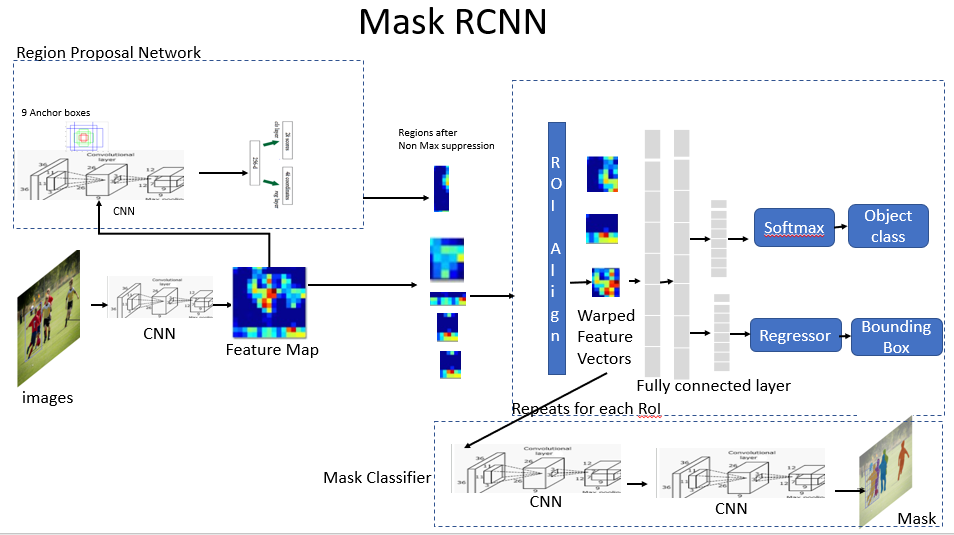

### **1.Importing Libraries** <a class="anchor" id="1"></a>

In [1]:
import os
import json
import re
import cv2
import torch
import pickle
import random
import numpy as np
import torch.nn as nn
import matplotlib.cm as cm
import torch.optim as optim
from torchinfo import summary
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F
from nltk.corpus import stopwords
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset

torch.cuda.empty_cache()
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

### **2.Helper Functions** <a class="anchor" id="2"></a>

In [2]:
vocab_size = 1000
batch_size = 32

def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def generate_vocab(x,vocab_size=vocab_size):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '' and len(word)>1:
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:vocab_size]
    # creating a dict
    onehot_dict = {w:i+2 for i,w in enumerate(corpus_)}

    return onehot_dict

def tockenize(x_train,vocab=None):
    if vocab == None:
        vocab = generate_vocab(x_train)
    # tockenize
    final_list_train = []
    for sent in x_train:
        for word in sent.lower().split():
            if preprocess_string(word) in vocab.keys():
                final_list_train.append([vocab[preprocess_string(word)]])
            try:
                float(word)
                final_list_train.append([1]) # digits are 1
            except ValueError:
                pass

    return np.array(final_list_train)

def padding(sentences, seq_len):
    padded_sentences = []

    for sentence in sentences:
        sentence = np.array(sentence)
        size = sentence.shape[0]
        sentence = sentence.reshape((size,))
        if size >seq_len:
            padded_sentences.append(sentence[:seq_len])
        else:
            padding = np.zeros((seq_len-sentence.shape[0]))
            padded_sentences.append(np.append(padding,sentence))
            
    return np.array(padded_sentences).reshape((len(sentences),seq_len))

def accuracy(pred,target):
    acc = 0
    for i , j in zip(pred,target):
        if round(i[0]) == int(j[0]):
            acc = acc + 1
            
    return acc/len(pred)

### **3.Dataset Managament** <a class="anchor" id="3"></a>

#### 1.Initializing Dataset <a class="anchor" id="3.1"></a>

In [3]:
TRAIN_IMAGE_PATH = 'dataset/training_data/images/'
TRAIN_ANNOTATION_PATH = 'dataset/training_data/annotations/'
TEST_IMAGE_PATH = 'dataset/testing_data/images/'
TEST_ANNOTATION_PATH = 'dataset/testing_data/annotations/'

train_images_path = np.char.add(TRAIN_IMAGE_PATH,np.array(os.listdir(TRAIN_IMAGE_PATH)))
train_annotation_path = np.char.add(TRAIN_ANNOTATION_PATH,np.array(os.listdir(TRAIN_ANNOTATION_PATH)))

test_images_path = np.char.add(TEST_IMAGE_PATH,np.array(os.listdir(TEST_IMAGE_PATH)))
test_annotation_path = np.char.add(TEST_ANNOTATION_PATH,np.array(os.listdir(TEST_ANNOTATION_PATH)))

print(f'Number of Train Images : {len(train_images_path)}')
print(f'Number of Test Images : {len(test_annotation_path)}')

Number of Train Images : 149
Number of Test Images : 50


#### 2.Visualizing Dataset <a class="anchor" id="3.2"></a>

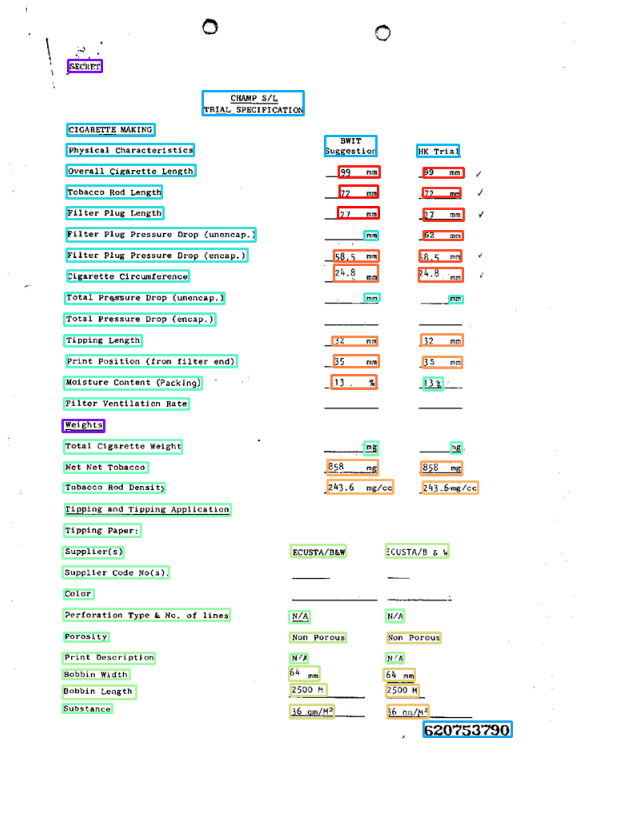

In [4]:
n = 10
thickness = 2
img = cv2.imread(train_images_path[n])

plt.figure(figsize=(50,50))

form = json.load(open(train_annotation_path[n]))['form']
colors = cm.rainbow(np.linspace(0, 1, len(form)))

color_code = {}
for box, color in zip(form, colors):
    id = box['id']
    link = box['linking']
    if len(link) != 0:
        for linked_id in link:
            color_code[linked_id[1]] = color
    color_code[id] = color

for i in form:
    color = (255, 0, 0, 0)

    bounding_vertex = tuple(i['box'])
    x_min, y_min, x_max, y_max = bounding_vertex
    img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color_code[i['id']][:-1]*255, thickness )

plt.subplot(3, 2, 1)
plt.axis('off')
plt.imshow(img)

In [5]:
form[4]

{'box': [71, 783, 127, 794],
 'text': 'Porosity',
 'label': 'question',
 'words': [{'box': [71, 783, 127, 794], 'text': 'Porosity'}],
 'linking': [[38, 4], [4, 46], [4, 50]],
 'id': 4}

In [6]:
link_dict = {}

for box in form:
    box_id = box['id']
    link_dict[box_id] = []
    for links in box['linking']:
        if box_id in links:
            links.remove(box_id)
        link_dict[box_id].append(links[0])

link_dict

{0: [],
 1: [34, 35, 36],
 2: [38, 44, 45],
 3: [38],
 4: [38, 46, 50],
 5: [38, 49, 53],
 6: [25, 18],
 7: [28, 19],
 8: [28, 18],
 9: [32, 19],
 10: [34, 18],
 11: [34, 19],
 12: [40],
 13: [40],
 14: [41],
 15: [41],
 16: [],
 17: [],
 18: [71, 72, 73, 6, 64, 63, 8, 60, 61, 62, 10, 56, 55],
 19: [70, 69, 68, 67, 66, 65, 7, 59, 58, 9, 11, 57, 54],
 20: [],
 21: [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
 22: [21, 71, 70],
 23: [21, 72, 69],
 24: [21, 73, 68],
 25: [21, 6, 67],
 26: [21, 64, 66],
 27: [21, 63, 65],
 28: [21, 8, 7],
 29: [21],
 30: [21, 60, 59],
 31: [21, 61, 58],
 32: [21, 62, 9],
 33: [21],
 34: [1, 10, 11],
 35: [1, 56, 57],
 36: [1, 55, 54],
 37: [],
 38: [2, 39, 3, 40, 4, 41, 42, 43, 5],
 39: [38],
 40: [38, 13, 12],
 41: [38, 15, 14],
 42: [38, 47, 51],
 43: [38, 48, 52],
 44: [2],
 45: [2],
 46: [4],
 47: [42],
 48: [43],
 49: [5],
 50: [4],
 51: [42],
 52: [43],
 53: [5],
 54: [36, 19],
 55: [36, 18],
 56: [35, 18],
 57: [35, 19],
 58: [31, 19],
 59: [30

In [7]:
classes = []
for box in json.load(open(train_annotation_path[0]))['form']:
    if box['label'] not in classes:
        classes.append(box['label'])

print(classes)

['other', 'question', 'answer', 'header']


711 18.113517397105614


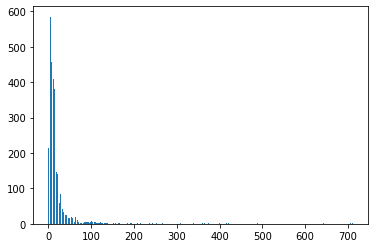

In [8]:
text_comp = {}
max_len = 0
avg_len = 0
n_sentence = 0
text_data = []
train_text_encoded = []
test_text_encoded = []
train_linked_dict = []
test_linked_dict = []
train_label = []
test_label = []
train_boxes = []
test_boxes = []

for idx, train_val_path in enumerate([train_annotation_path,test_annotation_path]):
    for paths in train_val_path:
        temp = []
        temp_box = []
        temp_label = []
        link_dict = {}
        with open(paths,encoding='utf-8') as file:
           for box in json.load(file)['form']:
                text_data.append(box['text'])
                temp.append(box['text'])
                temp_label.append(classes.index(box['label']))
                temp_box.append(box['box'])
                box_id = box['id']
                link_dict[box_id] = []

                for links in box['linking']:
                    if box_id in links:
                        links.remove(box_id)
                    link_dict[box_id].append(links[0])

                text_len = len(text_data[-1])
                if text_len not in text_comp.keys():
                    text_comp[text_len] = 1
    
                else:
                    text_comp[text_len] = text_comp[text_len] + 1
    
                if max_len<text_len:
                    max_len = text_len
    
                avg_len = avg_len + text_len
                n_sentence+=1
                
        if idx == 0:
            train_text_encoded.append(temp)
            train_boxes.append(temp_box)
            train_label.append(temp_label)
            train_linked_dict.append(link_dict)
        else:
            test_text_encoded.append(temp)
            test_boxes.append(temp_box)
            test_label.append(temp_label)
            test_linked_dict.append(link_dict)
            
print(max_len,avg_len/(n_sentence))
plt.bar(list(text_comp.keys()), text_comp.values())
plt.show()

#### 3.Dataset and DataLoaders <a class="anchor" id="3.2"></a>

In [9]:
seq_len = 50
vocab = generate_vocab(text_data,vocab_size=-1)
pickle.dump(vocab,open("saved_models/vocab",'wb'))
for i, forms in enumerate(train_text_encoded):
    train_text_encoded[i] = padding(tockenize(train_text_encoded[i],vocab=vocab),seq_len=seq_len)
for i, forms in enumerate(test_text_encoded):
    test_text_encoded[i] = padding(tockenize(test_text_encoded[i],vocab=vocab),seq_len=seq_len)


In [10]:
class siamese_dataset(Dataset):
    def __init__(self, train_annotation_path, text_encoded,classes=classes):
        self.path = train_annotation_path
        self.len_imgs = len(self.path)
        self.linked_dicts_all = []
        self.classes = classes
        self.vocab = {}
        self.text_encoded = text_encoded

        for each_path in self.path:
            link_dict = {}
            for box in json.load(open(each_path,encoding='utf-8'))['form']:
                box_id = box['id']
                link_dict[box_id] = []

                for links in box['linking']:
                    if box_id in links:
                        links.remove(box_id)
                    link_dict[box_id].append(links[0])

            self.linked_dicts_all.append(link_dict)

    def __getitem__(self, index):
        item1 , item2 , label, id,n_img = None , None , None, None, None
        valid = False
        while not valid:
            n_img  = np.random.randint(0,self.len_imgs)
            for i in self.linked_dicts_all[n_img].values():
                if len(i)!=0:
                    valid = True
                    break

        with open(self.path[n_img],encoding='utf-8') as file:
            form = json.load(file)['form']
            n_items = len(form)
    
            if index%2 == 0: # same item
                label = 1
                while True:
                    id = np.random.randint(0,n_items)
                    if len(self.linked_dicts_all[n_img][id])!=0: #skip unlinked
                        break
                    
                item1 = [[self.text_encoded[n_img][id]],self.classes.index(form[id]['label']),form[id]['box']]
                id = np.random.choice(self.linked_dicts_all[n_img][id])
                item2 = [[self.text_encoded[n_img][id]],self.classes.index(form[id]['label']),form[id]['box']]
                
            else:
                label,id2 = 0, None
                id = np.random.randint(0,n_items)
                item1 = [[self.text_encoded[n_img][id]],self.classes.index(form[id]['label']),form[id]['box']]
                while True:
                    id2 = random.randrange(0,n_items)
                    if id2 not in self.linked_dicts_all[n_img][id] and id2 != id: #skip linked
                        break
                item2 = [[self.text_encoded[n_img][id2]],self.classes.index(form[id2]['label']),form[id2]['box']]

        return torch.LongTensor(item1[0][0]),torch.LongTensor(item2[0][0]),torch.FloatTensor([item1[1]]),torch.FloatTensor([item2[1]]),torch.FloatTensor(item1[2]),torch.FloatTensor(item2[2]),torch.FloatTensor([label])


    def __len__(self):
        total_comb = 0
        for path in self.path:
            total_comb = total_comb + len(json.load(open(path,encoding='utf-8'))['form'])

        return total_comb

    def init_vocab(self,vocab):
        self.vocab = vocab



In [11]:
seq_len = 30
train_dataset = siamese_dataset(train_annotation_path,train_text_encoded,classes=classes)
train_dataset.init_vocab(vocab=vocab)

test_dataset = siamese_dataset(test_annotation_path,test_text_encoded,classes=classes)
test_dataset.init_vocab(vocab=vocab)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(train_dataloader.__len__())

232


### **4.Initializing pre-trained model** <a class="anchor" id="4"></a>

In [12]:
torch.cuda.empty_cache()

class siamese_multi_head(nn.Module):
    def __init__(self,device,hidden_size,n_layer,embedding_size):
        super().__init__()
        if 'embs_npa.npy' in os.listdir('saved_models/'):
            embs_npa = np.load('saved_models/embs_npa.npy')
        
        self.device = device
        self.n_layer = n_layer
        self.hidden_size = hidden_size

        # Sentence embeddings
        self.embedding_layer = nn.Embedding.from_pretrained(torch.from_numpy(embs_npa).float(),freeze=False)
        self.lstm_layer = nn.LSTM(embedding_size,hidden_size,n_layer,batch_first = True)

        #label layer
        self.label_l = nn.Linear(1,1)
        # combined
        self.l1 = nn.Linear(hidden_size+1+4,32)
        self.l2 = nn.Linear(32,1)

    def forward(self,x_words, x_labels, x_box):
        x_words_1 = self.embedding_layer(x_words[0])
        _ , (x_words_1,__) = self.lstm_layer(x_words_1)
        x_words_1 = F.relu(x_words_1[-1])

        x_words_2 = self.embedding_layer(x_words[1])
        _ , (x_words_2,__) = self.lstm_layer(x_words_2)
        x_words_2 = F.relu(x_words_2[-1])

        x_labels_1 = self.label_l(x_labels[0])
        x_labels_2 = self.label_l(x_labels[1])

        x_words = torch.abs(x_words_1-x_words_2)
        x_labels = torch.abs(x_labels_1-x_labels_2)
        x_box = torch.abs(x_box[0]-x_box[1])

        x = torch.cat([x_labels,x_box,x_words],dim=1)
        x = F.relu(self.l1(x))
        x = torch.sigmoid(self.l2(x))

        return x

device = 'cuda'
model = siamese_multi_head('cpu',hidden_size = 64,n_layer= 2,embedding_size = 50).to(device)

criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(),lr = 0.001)


In [13]:
summary(model,[(2,1,seq_len), (2,1,1), (2,1,4)], dtypes=[torch.long, torch.float, torch.float])

Layer (type:depth-idx)                   Output Shape              Param #
siamese_multi_head                       --                        --
├─Embedding: 1-1                         [1, 30, 50]               20,000,100
├─LSTM: 1-2                              [1, 30, 64]               62,976
├─Embedding: 1-3                         [1, 30, 50]               (recursive)
├─LSTM: 1-4                              [1, 30, 64]               (recursive)
├─Linear: 1-5                            [1, 1]                    2
├─Linear: 1-6                            [1, 1]                    (recursive)
├─Linear: 1-7                            [1, 32]                   2,240
├─Linear: 1-8                            [1, 1]                    33
Total params: 20,065,351
Trainable params: 20,065,351
Non-trainable params: 0
Total mult-adds (M): 43.78
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 80.26
Estimated Total Size (MB): 80.29

### **5.Training** <a class="anchor" id="5"></a>

In [14]:
epoch = 100
loss_history = [[],[]]
accuracy_history = [[],[]]
train_n_minibatches = train_dataloader.__len__()
validation_n_minibatches = test_dataloader.__len__()
best_test_acc = 0

log_idx = int(train_n_minibatches//1)

for e in range(epoch):
    for batch_idx , (x_words1, x_words2, x_labels1, x_labels2, x_box1, x_box2, y) in enumerate(train_dataloader):
        torch.cuda.empty_cache()
        model.train() # Setting mode to train
        optimizer.zero_grad()
        y_pred  = model([x_words1.to(device), x_words2.to(device)], [x_labels1.to(device), x_labels2.to(device)], [x_box1.to(device), x_box2.to(device)])
        # Calculating Loss
        y = y.to(device)
        loss = criterion(y_pred,y)
        loss_history[0].append(float(loss.detach()))
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), epoch)
        optimizer.step()
        
        #Calaculating Accuracy
        y_pred = y_pred.cpu().detach().numpy().tolist()
        y = y.cpu().detach().numpy().tolist()
        accuracy_history[0].append(accuracy(y_pred,y)*100)

    print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
    print(f'TRAIN LOSS : {sum(loss_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}',end = ' ')
    print(f'TRAIN ACCURACY : {sum(accuracy_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}')
    
    with torch.no_grad():
        for batch_idx , (x_words1, x_words2, x_labels1, x_labels2, x_box1, x_box2, y) in enumerate(test_dataloader):
            model.eval()
            y_pred  = model([x_words1.to(device), x_words2.to(device)], [x_labels1.to(device), x_labels2.to(device)], [x_box1.to(device), x_box2.to(device)])
            # Calculating Loss
            y = y.to(device)
            loss = criterion(y_pred,y)
            loss_history[1].append(float(loss.detach()))
            
            #Calaculating Accuracy
            y_pred = y_pred.cpu().detach().numpy().tolist()
            y = y.cpu().detach().numpy().tolist()
            accuracy_history[1].append(accuracy(y_pred,y)*100)           
        
    test_acc = sum(accuracy_history[1][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches
    if test_acc>best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(),f'saved_models/siamese_multi_head_{str(best_test_acc)[:6]}')

    print(f'VALIDATION LOSS : {sum(loss_history[1][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}',end = ' ')
    print(f'VALIDATION ACCURACY : {test_acc}')
    print('---------------------------------------------------------------------------------------------')

---------------------------------------EPOCH 1-------------------------------------------
TRAIN LOSS : 0.43267392469891186 TRAIN ACCURACY : 83.04999432849365
VALIDATION LOSS : 0.29931725929044695 VALIDATION ACCURACY : 87.95865949119374
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 2-------------------------------------------
TRAIN LOSS : 0.29247684346447733 TRAIN ACCURACY : 88.37553879310344
VALIDATION LOSS : 0.30670413415725917 VALIDATION ACCURACY : 86.4481409001957
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 3-------------------------------------------
TRAIN LOSS : 0.2799172155430605 TRAIN ACCURACY : 89.0171279491833
VALIDATION LOSS : 0.26434387950456306 VALIDATION ACCURACY : 89.37133072407045
---------------------------------------------------------------------------------------------
-------------

### **6.Plotting Graphs** <a class="anchor" id="6"></a>

# 1.Plotting Accuracy vs Epoch<a class="anchor" id="6.1"></a>

In [15]:
best_test_acc

92.12328767123287

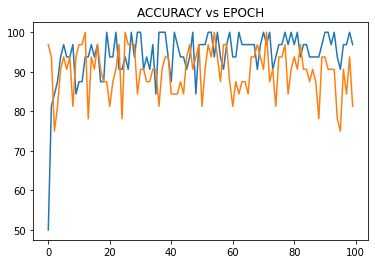

In [16]:
plt.plot(accuracy_history[0][::train_n_minibatches])
plt.plot(accuracy_history[1][::validation_n_minibatches])
plt.title('ACCURACY vs EPOCH')
plt.show()


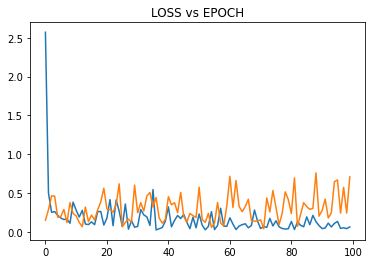

In [17]:
plt.plot(loss_history[0][::train_n_minibatches])
plt.plot(loss_history[1][::validation_n_minibatches])
plt.title('LOSS vs EPOCH')
plt.show()